# Model fine-tuning

## Initialization

#### Setup project paths:

In [1]:
from os.path import join, exists

models_path = join("Models")
datasets_path = join("Source datasets")
lesa_model_path = join(models_path, 'LESA')
lesa_dbs_path = join(datasets_path, 'LESA-EACL-2021')
print('Done')

Done


#### Install necessary packages:

In [ ]:
# Version of pip libraries with which LESA was tested and found working
%pip install keras==2.10.0
%pip install tensorflow-gpu==2.10.0
%pip install tensorflow-estimator==2.10.0
%pip install tensorflow-io-gcs-filesystem==0.31.0
%pip install numpy==1.24.2
%pip install pandas==1.5.3
%pip install scikit-learn==1.2.1
%pip install scipy==1.10.1
%pip install matplotlib-inline==0.1.6
%pip install h5py==3.8.0
%pip install nltk==3.8.1
%pip install regex==2022.10.31
%pip install tqdm==4.64.1
%pip install transformers==4.26.1
%pip install tokenizers==0.13.2
%pip install gdown
%pip install py-markdown-table
%pip install matplotlib

In [ ]:
# Version of pip libraries with which XLMRoberta and DeBerta were tested and found working
%pip install tensorflow-gpu==2.10.0
%pip install transformers==4.45.1
%pip install datasets==3.0.1
%pip install keras-hub==0.17.0
%pip install tf_keras==2.16.0
%pip install Keras-Preprocessing==1.1.2
%pip install tensorflow-text==2.16.1
%pip install py-markdown-table
%pip install matplotlib


#### Dataset tools:

In [9]:
import os
import sys
import ast
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List
from pandas import DataFrame, Series
from py_markdown_table.markdown_table import markdown_table

# Enable tqdm for pandas
tqdm.pandas()

# ANSI Highlighting: https://stackoverflow.com/a/21786287
h_stop = '\x1b[0m'
rh_start = '\x1b[1;30;41m'
gh_start = '\x1b[1;30;42m'
yh_start = '\x1b[1;30;43m'

def extract_language(dataset: DataFrame, lang: str, col: str = 'lang') -> DataFrame:
    """
    Extract the subset of the dataset containing only the samples of specified language.
    :param dataset: Source dataset.
    :param lang: The language to be extracted.
    :param col: The name of the column in the dataset that reffers to the language information.
    :returns: A DataFrame subset containing only the samples of specified language.
    """
    return dataset[dataset[col].isin([lang])]

def extract_subset(dataset: DataFrame, lang_path: str, lang: str, max_samples=20000) -> DataFrame:
    """Extract the language specific subset and save it to the specified path. """
    subset_path = join(lang_path, f'{lang}.csv')
    # Extract language specific samples
    if exists(subset_path):
        # In case the files already exist, don't re-generate them
        dataset = pd.read_csv(subset_path, sep='\t')
    else:
        print(f'\t Extracting language: {lang}')
        dataset = extract_language(dataset, lang).reset_index(drop=True)
        dataset = dataset if dataset.shape[0] <= max_samples else dataset[:max_samples]

        # Save the resulting entities together with the original data
        dataset.to_csv(subset_path, header=True, index=False, sep='\t')
        print(f'\tDataset saved to {subset_path}')

    return dataset

def extract_subsets(dataset: DataFrame, lang_path: str, languages=['en'], max_samples=20000) -> tuple:
    """Extract the list of language specific subsets and save them to the specified path. """

    subsets = []
    for lang in languages:
        # Create a folder if necessary
        print(f'Processing language: {lang}')
        sub_lang_path = join(lang_path, lang)
        os.makedirs(sub_lang_path, exist_ok=True)
        # Extract and save the data into a .csv file
        subset = extract_subset(dataset, sub_lang_path, lang, max_samples)
        subsets.append(subset)

    return tuple(subsets)


def split_dataset(dataset: DataFrame, split_ratio=None) -> List:
    """
    Split dataset into the train dev and test subsets.
    :param dataset: source dataset.
    :param split_ratio: The ratio of the split. Expects 2 boundary values to split the interval into 3 parts.
    :return: Training, validation and testing subset of the source dataset.
    """
    if split_ratio is None:
        split_ratio = [0.7, 0.15]
    else:
        assert len(split_ratio) == 2, 'Expected 2 boundary values to split the dataset into 3 parts!'

    idx = [int(dataset.shape[0] * split_ratio[i]) for i in range(2)]

    train = dataset.iloc[:idx[0]].copy()
    dev = dataset.iloc[idx[0]: idx[0] + idx[1]].copy()
    test = dataset.iloc[idx[0] + idx[1]:, :].copy()

    return train, dev, test


def shuffle_dbs(dataset: DataFrame) -> DataFrame:
    """
    Shuffle the samples withing the specified dataset.
    :param dataset: Source dataset.
    :return: The shuffled
    """
    return dataset.sample(frac=1).reset_index(drop=True)

def load_clef(path: str, lang: str, ver='22', task='1A') -> tuple[DataFrame, DataFrame, DataFrame]:
    """
    Load's a particular language from a dataset folder structure.
     :param path: Path to a folder structure.
     :param lang: Particular language.
     :return: Train, validation and test set in a form of DataFrame.
     """
    # Format the path
    if ver == '22':
        prefix = f'CT22_{lang}_{task}_checkworthy_'
    elif ver == '23':
        prefix = f'CT23_{task}_checkworthy_{lang}_'
    else:
        print('Unsupported CLEF version!')
        return None, None, None

    # Load the data
    train = pd.read_csv(join(path, prefix + 'train.tsv'), sep='\t')
    dev = pd.concat([pd.read_csv(join(path, prefix + 'dev.tsv'), sep='\t'),
                      pd.read_csv(join(path, prefix + 'dev_test.tsv'), sep='\t')])
    test = pd.read_csv(join(path, prefix + 'test_gold.tsv'), sep='\t')

    # Format the DataFrame
    train_label = train[[col for col in train.columns if 'label' in col.lower()]]
    train_text = train[[col for col in train.columns if 'text' in col.lower()]]
    train = pd.concat([train_label, train_text], axis=1)
    train.columns = ['label', 'text']

    dev_label = dev[[col for col in dev.columns if 'label' in col.lower()]]
    dev_text = dev[[col for col in dev.columns if 'text' in col.lower()]]
    dev = pd.concat([dev_label, dev_text], axis=1)
    dev.columns = ['label', 'text']

    test_label = test[[col for col in test.columns if 'label' in col.lower()]]
    test_text = test[[col for col in test.columns if 'text' in col.lower()]]
    test = pd.concat([test_label, test_text], axis=1)
    test.columns = ['label', 'text']

    # Convert label values to 0 and 1 (if not already)
    # pd.set_option('future.no_silent_downcasting', True)
    train['label'] = train['label'].replace({'Yes': 1, 'No': 0})
    dev['label'] = dev['label'].replace({'Yes': 1, 'No': 0})
    test['label'] = test['label'].replace({'Yes': 1, 'No': 0})

    return train, dev, test

def levenshtein_dist(claim1, claim2, threshold=0.2):
    """
    Check if two claims are similar based on Levenshtein distance ratio.
    """
    distance = Levenshtein.distance(claim1, claim2)
    max_length = max(len(claim1), len(claim2))
    return distance / max_length <= threshold

def split_sentence_into_sets(sentence, max_length=512):
    sentences = []
    current_set = []
    words = sentence.split()

    for word in words:
        # Check the length of the current set + length of the new word + 1 (for space)
        if (len(" ".join(current_set)) + len(word)) < max_length:
            current_set.append(word)
        else:
            sentences.append(" ".join(current_set))
            current_set = []

    return sentences

print('done')

done


#### Charts and statistics:

In [3]:
from typing import List
from pandas import DataFrame, Series

class DistributionData:
    """
    The datastructure for chart visualization.
    """
    size: int
    data: List
    labels: List

    def __init__(self):
        self.size = 0
        self.data = []
        self.labels = []


# Distribution of the languages in the dataset
def lang_distribution(dataset: DataFrame, threshold=1000) -> DistributionData:
    languages_list = dataset['lang'].unique()  # Renamed to languages_list to avoid overwriting
    dist = DistributionData()
    dist.size = dataset.shape[0]

    # Initialize lists to store the transposed table data
    languages = []
    samples = []
    ratios = []

    for lang in languages_list:
        if lang is None:
            continue

        subset = extract_language(dataset, lang)
        if subset.shape[0] > threshold:
            dist.data.append(subset.shape[0])
            dist.labels.append(lang)
            languages.append(lang)
            samples.append(str(subset.shape[0]))
            ratios.append(f"{round((subset.shape[0] / dist.size) * 100.0, 2)}%")

    # Generate the markdown table
    header = "| Languages: | " + " | ".join(languages) + " |\n"
    separator = "|------------|" + "-------|" * len(languages) + "\n"
    samples_row = "| Samples:   | " + " | ".join(samples) + " |\n"
    ratios_row = "| Ratio:     | " + " | ".join(ratios) + " |\n"

    markdown_table = header + separator + samples_row + ratios_row
    print(markdown_table)

    return dist

# Distribution of the label 0 to label 1 in the dataset
def class_distribution(dataset: DataFrame) -> DistributionData:
    dist = DistributionData()
    dist.size = dataset.shape[0]

    class_0 = dataset.loc[dataset['label'] == 0]
    class_1 = dataset.loc[dataset['label'] == 1]
    size_0 = class_0.shape[0]
    size_1 = class_1.shape[0]

    dist.data.append(size_0)
    dist.labels.append('class 0')
    dist.data.append(size_1)
    dist.labels.append('class 1')

    table = [{'Class 0:': str(round((size_0 / dist.size) * 100.0, 2)) + '%',
              'Class 1:': str(round((size_1 / dist.size) * 100.0, 2)) + '%'}]


    markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
    print(markdown.replace('```',''))
    return dist


# Distribution of the label 0 to label 1 in the dataset within each language
def lang_classes_distribution(dataset: DataFrame) -> DistributionData:
    languages = dataset['lang'].unique()

    dist = DistributionData()
    dist.size = dataset.shape[0]

    table = []
    for lang in languages:
        if lang is None:
            continue

        subset = extract_language(dataset, lang)
        class_0 = subset.loc[subset['label'] == 0]
        class_1 = subset.loc[subset['label'] == 1]
        size_0 = class_0.shape[0]
        size_1 = class_1.shape[0]

        dist.data.append(size_0)
        dist.labels.append(f'{lang}: class 0')
        dist.data.append(size_1)
        dist.labels.append(f'{lang}: class 1')

        table.append({'Language:': lang,
                      'Class 0:': size_0,
                      'Class 0 Ratio:': str(round((size_0 / dist.size) * 100.0, 2)) + '%',
                      'Class 1:': size_1,
                      'Class 1 Ratio:': str(round((size_1 / dist.size) * 100.0, 2)) + '%'})

    markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
    print(markdown.replace('```',''))
    return dist


# Pie chart of the DistributionData
def pie_chart(title: str, data: DistributionData):
    # Output in high quality.
    %config InlineBackend.figure_format = 'retina'

    print(f'{title}')
    fig, ax = plt.subplots(figsize=(5, 5))

    patches, texts, pcts = ax.pie(
        data.data, labels=data.labels, autopct='%.1f%%',
        wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},
        textprops={'fontsize': 10},
        startangle=90)

    for i, patch in enumerate(patches):
        texts[i].set_color(patch.get_facecolor())

    plt.setp(pcts, color='white')
    plt.setp(texts, fontweight=600)
    ax.set_title(title, fontsize=13)
    plt.tight_layout()
    plt.show()


def stacked_chart(title: str, data: DistributionData):
    print(f'{title}')
    fig, ax = plt.subplots(figsize=(7, 5))

    # Assuming data.data is a list of lists for stacked bars
    data_values = np.array(data.data)
    num_bars = data_values.shape[1]
    indices = np.arange(num_bars)

    # Stack the bars
    bottom = np.zeros(num_bars)
    for i, (d, label) in enumerate(zip(data_values, data.labels)):
        ax.bar(indices, d, label=label, bottom=bottom)
        bottom += d

    ax.set_title(title, fontsize=13)
    ax.legend()
    ax.set_xlabel('Categories')
    ax.set_ylabel('Values')
    plt.xticks(indices, [f'Category {i+1}' for i in range(num_bars)])
    plt.tight_layout()
    plt.show()


def histogram(datasets: dict):
  df_histogram = pd.DataFrame()

  table = []
  for name, value in datasets.items():
      # Calculate the length of each sentence and store it in a new column 'length'
      df_histogram[name] = value['text'].str.len()

      # Filter the DataFrame to keep only rows where the length is less than or equal to 500
      df_histogram = df_histogram[df_histogram[name] <= 500]

      # Reset the index of the filtered DataFrame
      df_histogram = df_histogram.reset_index(drop=True)

      table.append({'Dataset': name,
                    'Avg. length:': round(df_histogram[name].mean(), 2)})

  markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
  print(markdown.replace('```',''))

  # Plot a histogram of sentences length
  df_histogram.plot(kind='hist',
                  alpha=0.7,
                  bins=100,
                  title='Histogram of sentence lengths for various datasets.',
                  rot=45,
                  grid=True,
                  figsize=(12, 8),
                  fontsize=15,
                  color=['#A0E8AF2B', '#FFCF562B', '#79ABE82B', '#E846252B', '#003153', '#7400FF'])
  plt.xlabel('Length of the sentence')
  plt.ylabel("Number of samples")
  plt.show()

print('Done')

Done


## Datasets

### ClaimBuster dataset [Paper](https://arxiv.org/pdf/2004.14425v1)  [Data](https://zenodo.org/records/3836810)

The ClaimBuster dataset consists of statements extracted from all U.S. general election presidential debates (1960-2016) along with human-annotated check-worthiness labels where each sentence is categorized into one of the three categories: non-factual statement, unimportant factual statement, and check-worthy factual statement.

The ClaimBuster dataset consists of six files as follows:
* groundtruth.csv, (22,501 sentences)
* crowdsourced.csv, (1032 sentences)
* all_sentences.csv, (32,072 sentences)
* 2xNCS.json, (8292 sentences)
* 2.5xNCS.json, (9674 sentences)
* 3xNCS.json, (11,056 sentences)
* 
Also, all 33 presidential debate transcript files are provided as additional files in the folder “debate_transcripts”.

The files groundtruth.csv, crowdsourced.csv, and all_sentences.csv are for the paper: [A Benchmark Dataset of Check-worthy Factual Claims](https://arxiv.org/pdf/2004.14425v1)

2xNCS.json, 2.5xNCS.json, 3xNCS.json were all gathered from groundtruth.csv and crowdsourced.csv using stricter criteria with respect to the labels assigned to them. So, we expect these sets to be of higher quality and from experience we see that they produce better models. These were used in training models in the paper: Gradient-Based Adversarial Training on Transformer Networks for Detecting Check-Worthy Factual Claims. A sentence is assigned one of two classes non-check-worthy sentence (0) or check-worthy factual sentence (1). Each file has a strict ratio of sentences in the non-checkworthy class to sentences in the check-worthy class. This ratio is denoted in the file name (i.e, 2x, 2.5x, 3x). The sentences are stored as a list of dictionaries, where each dictionary has the following attributes:
  - sentence_id: A unique numerical identifier to identify sentences in the dataset.
  - label: Assigned class label (1 when the sentence is CFS, and 0 when the sentence is NCS). 
  - text: A sentence spoken by a debate participant.

|Samples:|Class 0:|Class 1:|
|--------|--------|--------|
|  23533 |  17882 |  5651  |

#### Download the dataset:

In [3]:
import os
import shutil
import requests
import zipfile
from os.path import join

# Define paths
download_url = 'https://zenodo.org/records/3836810/files/ClaimBuster_Datasets.zip?download=1'
zip_file_path = join(datasets_path, 'ClaimBuster_Datasets.zip')
claimbuster_dst_dir = join(datasets_path, 'ClaimBuster')

# Only download the dataset if necessary
if not os.path.exists(claimbuster_dst_dir):
    %pip install requests

    # Download the ZIP file
    print('Downloading ClaimBuster dataset: ', end='')
    response = requests.get(download_url, stream=True)
    with open(zip_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print('ok')

    # Ensure the destination directory exists
    os.makedirs(claimbuster_dst_dir, exist_ok=True)

    # Extract the ZIP file
    print('Extracting data: ', end='')
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(claimbuster_dst_dir)
    print('ok')

    # Clean up the ZIP file
    os.remove(zip_file_path)

    # List the extracted files
    print("ClaimBuster dataset files:\n", "\n".join(os.listdir(claimbuster_dst_dir)))
else:
    print('ClaimBuster dataset ready.')


ClaimBuster dataset ready.


#### Load the dataset:

In [11]:
import pandas as pd

groundtruth = pd.read_csv(join('Source datasets', 'ClaimBuster', 'ClaimBuster_Datasets', 'datasets', 'groundtruth.csv'))
groundtruth = groundtruth[['Text','Verdict']]
groundtruth['Verdict'] = groundtruth['Verdict'].apply(lambda x: 1 if x == 1 else 0)
groundtruth.columns = ['text', 'label']

crowdsourced = pd.read_csv(join('Source datasets', 'ClaimBuster', 'ClaimBuster_Datasets', 'datasets', 'crowdsourced.csv'))
crowdsourced = crowdsourced[['Text','Verdict']]
crowdsourced['Verdict'] = crowdsourced['Verdict'].apply(lambda x: 1 if x == 1 else 0)
crowdsourced.columns = ['text', 'label']

# # Define the path to the JSON file
# json_file_path = os.path.join(datasets_path, 'ClaimBuster', 'ClaimBuster_Datasets', 'datasets', '2xNCS.json')

# # Load the JSON file
# with open(json_file_path, 'r') as file:
#     data = json.load(file)

# # Create a DataFrame from the JSON data
# ncs = pd.DataFrame(data, columns=['text', 'label'])

claimbuster = pd.concat([groundtruth, crowdsourced])
claimbuster['lang'] = 'en'
claimbuster['topic'] = 'None'
claimbuster['style'] = 'semi'
claimbuster = claimbuster[['lang', 'topic', 'style', 'label', 'text']]
# claimbuster = filter_dataframe(claimbuster)

class_0 = claimbuster[claimbuster['label'] == 0]
class_1 = claimbuster[claimbuster['label'] == 1]

table = []
table.append({'Samples:': claimbuster.shape[0],
              'Class 0:': class_0.shape[0],
              'Class 1:': class_1.shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))
print(f"\nColumns: {claimbuster.columns.tolist()}")

import pandas as pd
from os.path import join
from sklearn.model_selection import train_test_split

random_state = 42

# First, split into train+val and test sets, we do stratification instead of shuffling
train_val_df, test_df = train_test_split(claimbuster, test_size=0.2, random_state=random_state, stratify=claimbuster['label'])

# Then, split train+val into train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=random_state, stratify=train_val_df['label'])

clambuster_train = train_df[['text', 'label']]
clambuster_dev = val_df[['text', 'label']]
clambuster_test = test_df[['text', 'label']]

clambuster_train = clambuster_train.astype({'label':'int'})
clambuster_dev = clambuster_dev.astype({'label':'int'})
clambuster_test = clambuster_test.astype({'label':'int'})

|Samples:|Class 0:|Class 1:|
|--------|--------|--------|
|  23533 |  17882 |  5651  |

Columns: ['lang', 'topic', 'style', 'label', 'text']


#### Statistics:

### TrClaim19 dataset [Paper](https://aclanthology.org/2020.conll-1.31/?utm_source=chatgpt.com) [Data](https://github.com/YSKartal/TrClaim19)

|Samples:|Class 0:|Class 1:|
|--------|--------|--------|
|  23533 |  17882 |  5651  |

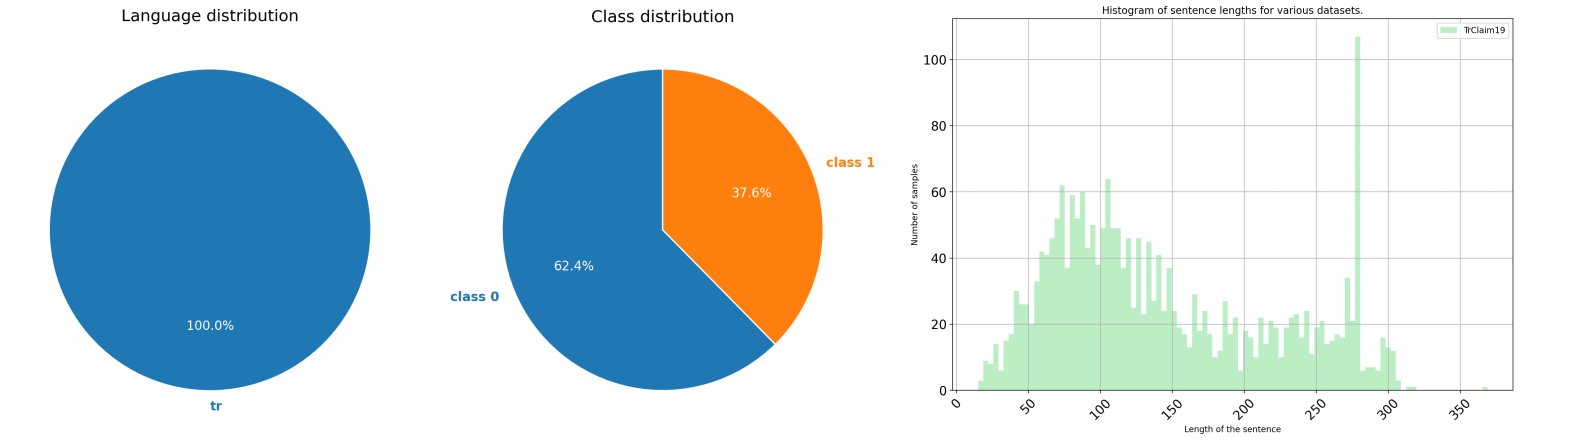

#### Load the dataset:

In [3]:
import os
import pandas as pd

url = "https://raw.githubusercontent.com/YSKartal/TrClaim19/main/trclaim19_v1_1.csv"
trclaim19 = pd.read_csv(url, sep='\t')[['tweet', 'check_worthiness']]
trclaim19.columns = ['text', 'label']
trclaim19['lang'] = 'tr'
trclaim19['topic'] = 'politics'
trclaim19['style'] = 'noisy'
trclaim19 = trclaim19[['lang', 'topic', 'style', 'label', 'text']]

# Ensure the destination directory exists
trclaim19_path = join(datasets_path, 'TrClaim19')
os.makedirs(trclaim19_path, exist_ok=True)
trclaim19.to_csv(join(trclaim19_path, 'TrClaim19.csv'), index=False, header=True)

class_0 = trclaim19[trclaim19['label'] == 0]
class_1 = trclaim19[trclaim19['label'] == 1]

table = []
table.append({'Samples:': trclaim19.shape[0],
              'Class 0:': class_0.shape[0],
              'Class 1:': class_1.shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))


import pandas as pd
from os.path import join
from sklearn.model_selection import train_test_split

random_state = 42

# First, split into train+val and test sets, we do stratification instead of shuffling
train_val_df, test_df = train_test_split(trclaim19, test_size=0.2, random_state=random_state, stratify=trclaim19['label'])

# Then, split train+val into train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=random_state, stratify=train_val_df['label'])

trclaim19_train = train_df[['text', 'label']]
trclaim19_dev = val_df[['text', 'label']]
trclaim19_test = test_df[['text', 'label']]

trclaim19_train = trclaim19_train.astype({'label':'int'})
trclaim19_dev = trclaim19_dev.astype({'label':'int'})
trclaim19_test = trclaim19_test.astype({'label':'int'})

|Samples:|Class 0:|Class 1:|
|--------|--------|--------|
|  2188  |  1365  |   823  |


#### Statistics:

| Languages: | tr |
|------------|-------|
| Samples:   | 2188 |
| Ratio:     | 100.0% |

TrClaim19 - Language distribution


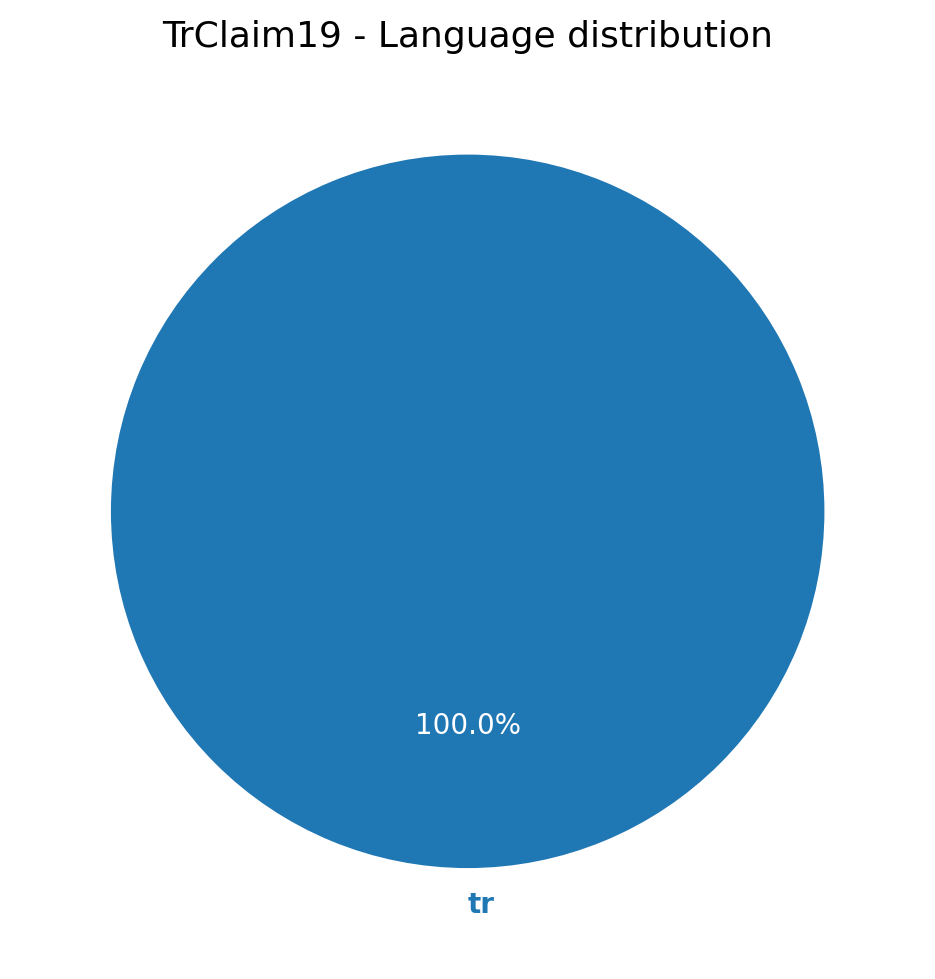

|Class 0:|Class 1:|
|--------|--------|
| 62.39% | 37.61% |
TrClaim19 - Class distribution


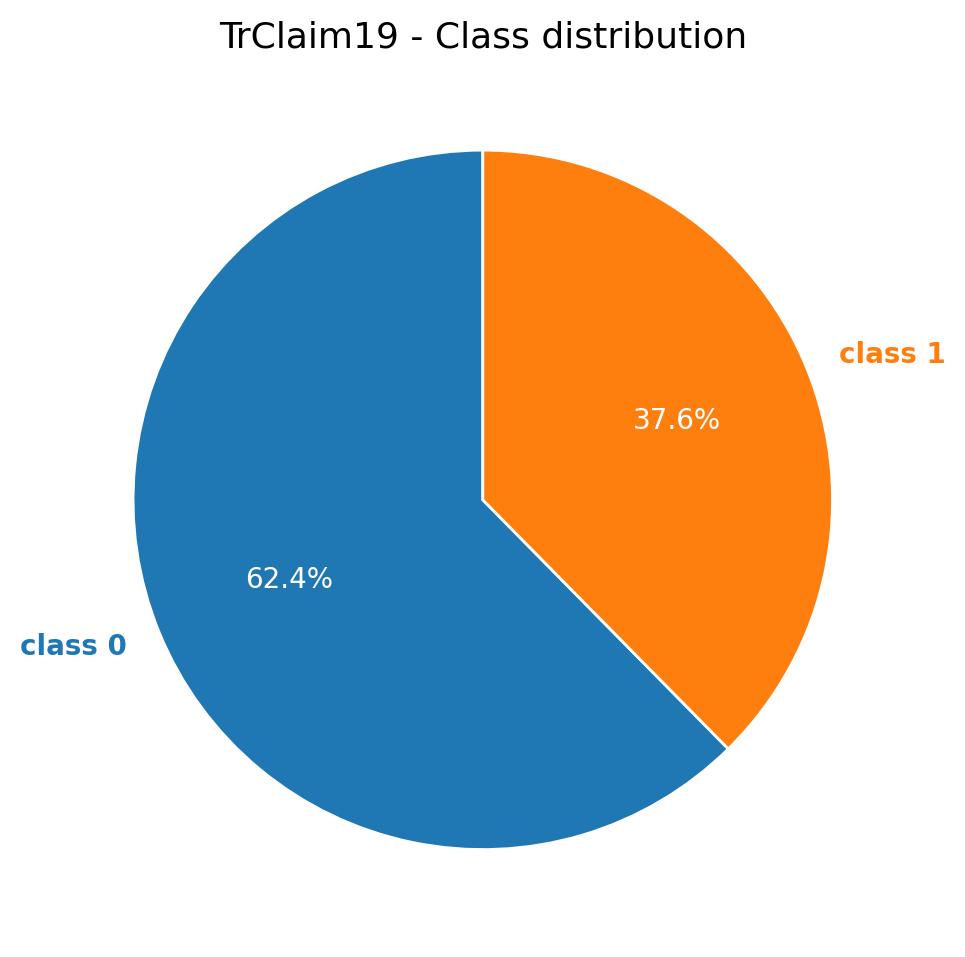

| Dataset |Avg. length:|
|---------|------------|
|TrClaim19|   104.95   |


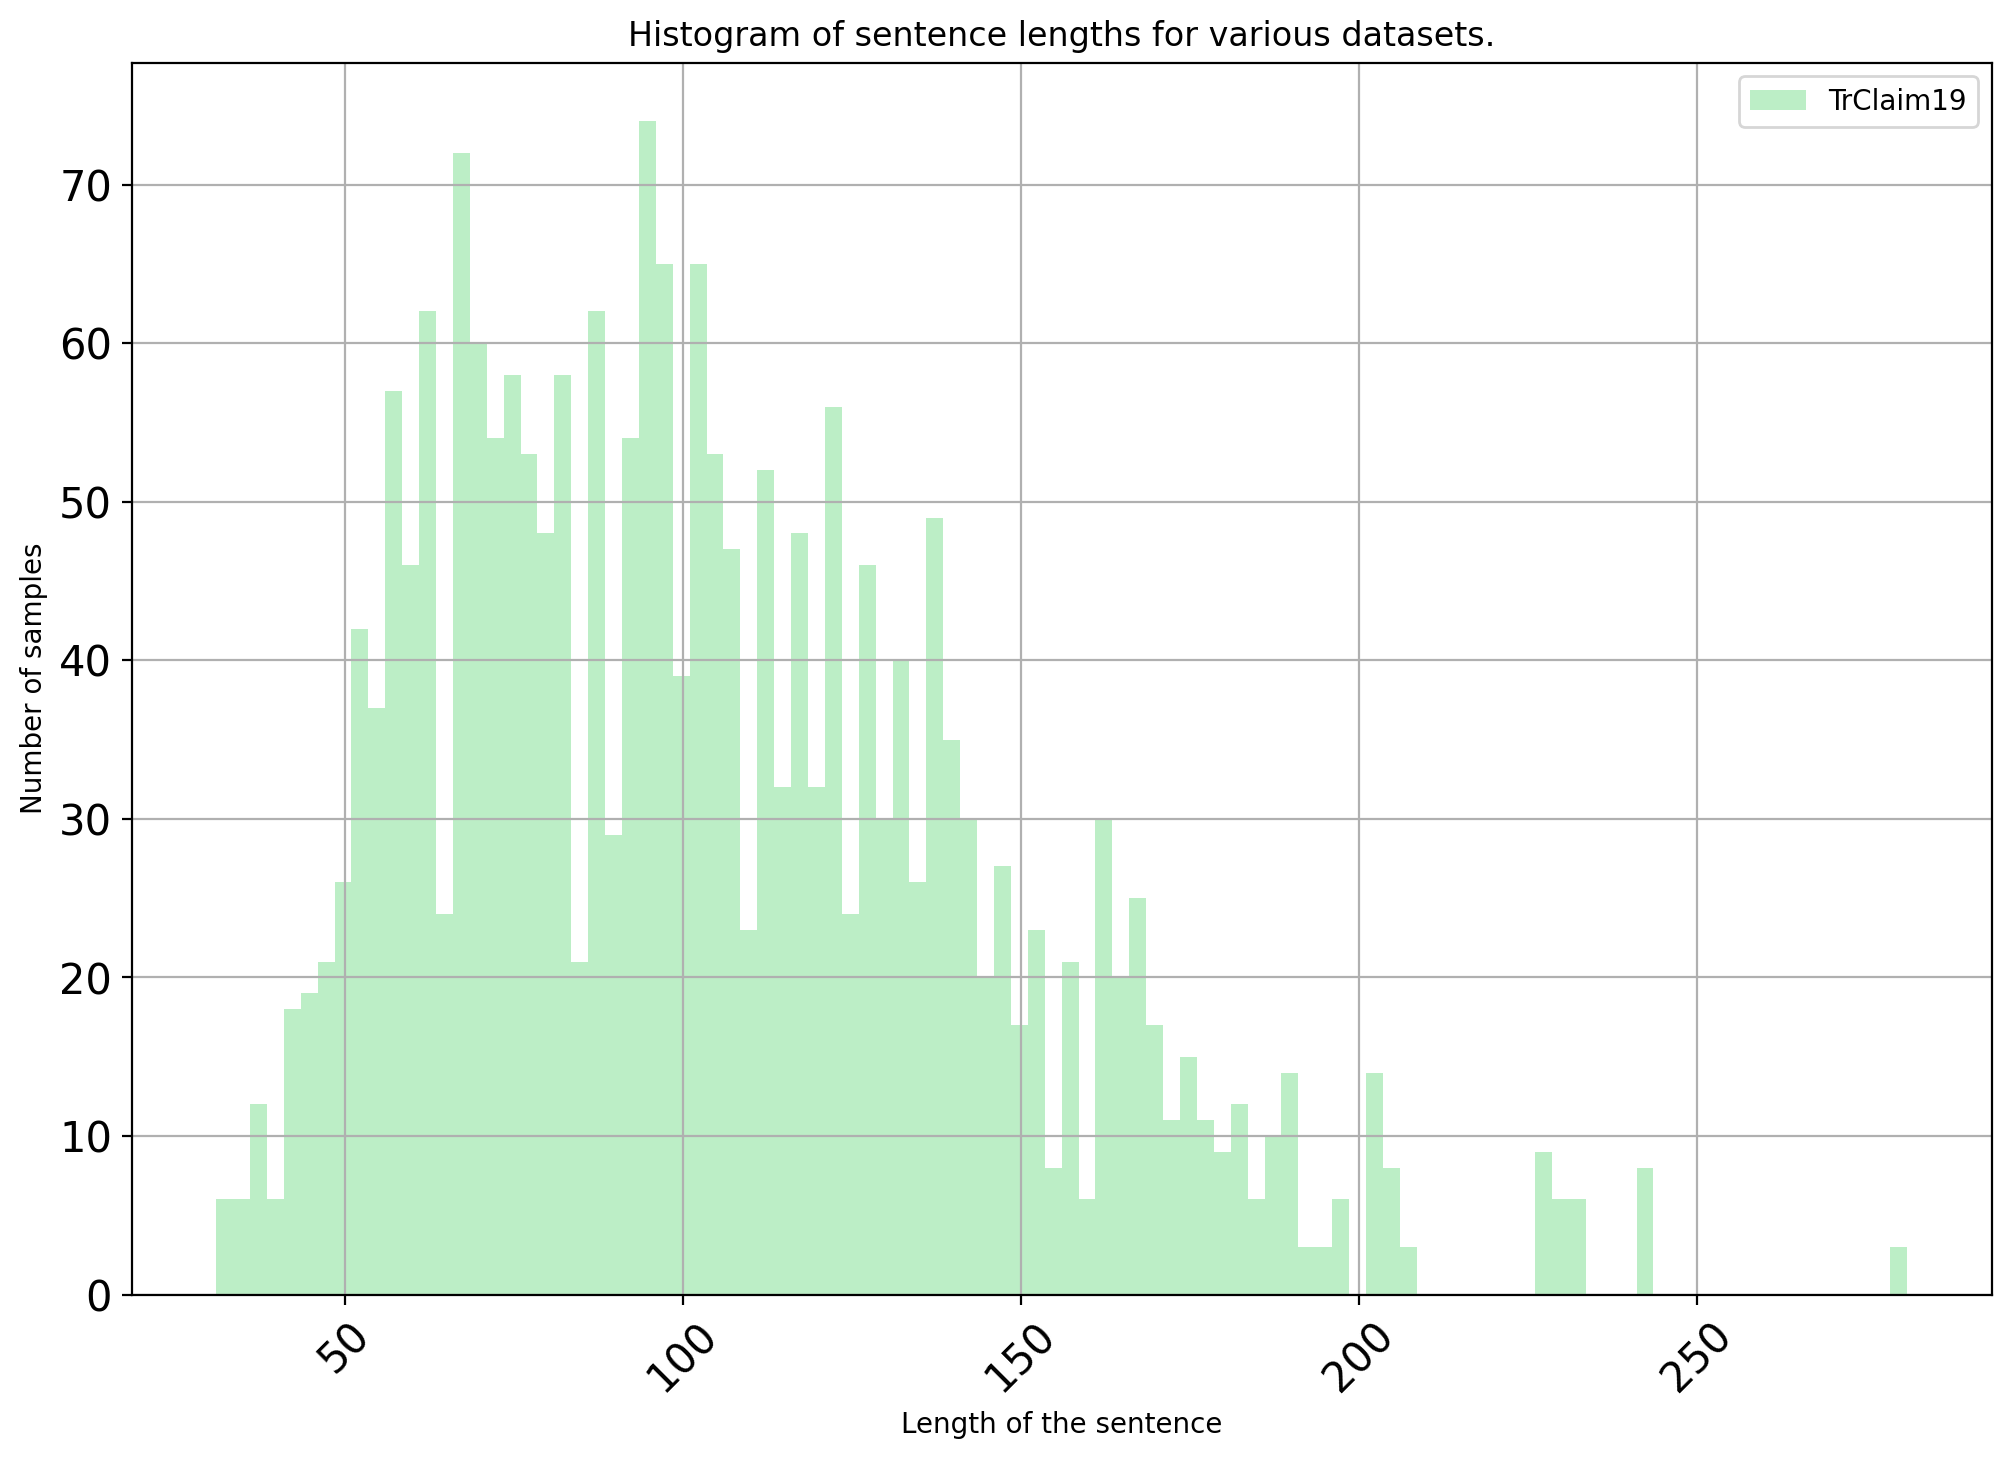

In [17]:
data = lang_distribution(trclaim19)
pie_chart(title='TrClaim19 - Language distribution', data=data)

data = class_distribution(trclaim19)
pie_chart(title='TrClaim19 - Class distribution', data=data)

histogram({'TrClaim19': trclaim19})

### LESA dataset

In [4]:
import glob
from os.path import join, exists
from py_markdown_table.markdown_table import markdown_table
from pandas import DataFrame

table = []

def flatten(_list):
    return [item for sublist in _list for item in sublist]

def extract_files(path: str) -> DataFrame:
    train = []
    dev = []
    test = []

    # Find paths of all the files with specific extension
    train_files = flatten([glob.glob(join(path, '*.train'))])
    dev_files = flatten([glob.glob(join(path, '*.dev'))])
    test_files = flatten([glob.glob(join(path, '*.test'))])

    # Read all samples from files into a perticular sets
    for _file in train_files:
      train.append(pd.read_csv(_file, header=None, sep='\t'))

    for _file in dev_files:
      dev.append(pd.read_csv(_file, header=None, sep='\t'))

    for _file in test_files:
      test.append(pd.read_csv(_file, header=None, sep='\t'))

    # Merge all the samples for each set and format it accordingly
    train = pd.concat(train)
    train.columns = ['text', 'label']
    dev = pd.concat(dev)
    dev.columns = ['text', 'label']
    test = pd.concat(test)
    test.columns = ['text', 'label']

    train = train.drop_duplicates()
    dev = dev.drop_duplicates()
    test = test.drop_duplicates()

    subset = pd.concat([train, dev, test])

    name = os.path.basename(os.path.normpath(path))
    table.append({'Name': name,
                  'Train': train.shape[0],
                  'Dev': dev.shape[0],
                  'Test': test.shape[0]})

    # data = class_distribution(subset)
    # pie_chart(title=f'{name} class distribution', data=data)

    return subset
    #return train, dev, test  # Uncomment in order to match the train, validation and test sets structured



tw = pd.read_csv(join(lesa_dbs_path, 'Twitter.csv'))[['tweet_text', 'claim']]
tw.columns = ['text', 'label']
tw_train, tw_dev, tw_test = split_dataset(tw, split_ratio=[0.8, 0.1])
table.append({'Name': 'Twitter',
              'Train': tw_train.shape[0],
              'Dev': tw_dev.shape[0],
              'Test': tw_test.shape[0]})
oc = extract_files(join(lesa_dbs_path, 'OC'))
wtp = extract_files(join(lesa_dbs_path, 'WTP'))
mt = extract_files(join(lesa_dbs_path, 'MT'))
pe = extract_files(join(lesa_dbs_path, 'PE'))
vg = extract_files(join(lesa_dbs_path, 'VG'))
wd = extract_files(join(lesa_dbs_path, 'WD'))

# Noisy dataset part
lesa_noisy = tw
lesa_noisy = lesa_noisy.drop_duplicates(subset=['text'], keep='first')
# Original split ratio of the dataset used by LESA model
noisy_train, noisy_dev, noisy_test = split_dataset(lesa_noisy, split_ratio=[0.8, 0.1])

# Semi-Noisy dataset part
lesa_semi = pd.concat([oc, wtp])
lesa_semi = lesa_semi.drop_duplicates(subset=['text'], keep='first')
# Original split ratio of the dataset used by LESA model
semi_train, semi_dev, semi_test = split_dataset(lesa_semi, split_ratio=[0.81, 0.095])

# Structured dataset part
lesa_struct = pd.concat([mt, pe, vg, wd])
lesa_struct = lesa_struct.drop_duplicates(subset=['text'], keep='first')
# Original split ratio of the dataset used by LESA model
struct_train, struct_dev, struct_test = split_dataset(lesa_struct, split_ratio=[0.82, 0.09])

lesa_train = pd.concat([noisy_train, semi_train, struct_train])
lesa_dev = pd.concat([noisy_dev, semi_dev, struct_dev])
lesa_test = pd.concat([noisy_test, semi_test, struct_test])

lesa2021 = pd.concat([lesa_train, lesa_dev, lesa_test])


table.append({'Name': 'Total',
              'Train': lesa_train.shape[0],
              'Dev': lesa_dev.shape[0],
              'Test': lesa_test.shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))

|  Name |Train| Dev|Test|
|-------|-----|----|----|
|Twitter| 7984| 998| 999|
|   OC  | 8533|5240|8393|
|  WTP  | 8412|5104|8322|
|   MT  | 449 | 284| 449|
|   PE  | 7051|4175|7051|
|   VG  | 2569|1553|2540|
|   WD  | 3878|2158|3775|
| Total |33125|3860|3863|


### MultiCW dataset - Balanced train/test split

In [2]:
# Load MultiCW model
import pandas as pd
from os.path import join
languages = pd.read_csv(join('Final-dataset', 'multicw.csv'))['lang'].unique()

multicw_path = join("Final-dataset")
multicw_train = pd.read_csv(join(multicw_path, "multicw-train.csv")).astype({'label':'int'})
multicw_dev = pd.read_csv(join(multicw_path, "multicw-dev.csv")).astype({'label':'int'})
multicw_test = pd.read_csv(join(multicw_path, "multicw-test.csv")).astype({'label':'int'})

multicw_train = multicw_train[['text', 'label']]
multicw_dev = multicw_dev[['text', 'label']]
multicw_test = multicw_test[['text', 'label', 'style']]

multicw_train.dropna(inplace=True)
multicw_dev.dropna(inplace=True)
multicw_test.dropna(inplace=True)

print(multicw_test.shape[0])

18444


## LESA model

### Definition

In [4]:
import sys
import os
import shutil
import warnings
from typing import Callable
import numpy as np
import pandas as pd

from keras_preprocessing.sequence import pad_sequences
from pandas import DataFrame
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from tqdm import tqdm
from transformers import BertTokenizer, AutoTokenizer

sys.path.insert(1, lesa_model_path)

from loader import sent2feature2ngram, ParentPositions, tokenize_sentences, create_attention_masks, \
    load_embedding_matrix, load_tokenizer, ind_model_noisy, ind_model_semi, ind_model_structured, final

# ANSI Highlighting: https://stackoverflow.com/a/21786287
h_stop = '\x1b[0m'
gh_start = '\x1b[1;30;42m'
rh_start = '\x1b[1;30;41m'


class LESAClaimModel():
    """ LESA: Linguistic Encapsulation and Semantic Amalgamation Based Generalised Claim Detection from Online
    Content accepted at EACL 2021. ArXiv paper [link](https://arxiv.org/abs/2101.11891) """

    def __init__(self):
        self.max_len = 30
        self.batch_size = 32

        self.final_model = None
        self.noisy_model = None
        self.semi_model = None
        self.structured_model = None

        self.noisy = None
        self.noisy_dev = None
        self.semi = None
        self.semi_dev = None
        self.struct = None
        self.struct_dev = None

        self.update_semantic_dbs = False

        # Set default semantic embedding datasets
        # self.set_semantic_datasets()

        # Init tokenizers as class variables
        print('Loading tokenizers: ', end='')

        # Original BERT model
        # model = os.path.join(lesa_model_path, 'bert-base')
        # self.bert_tokenizer_transformer = BertTokenizer.from_pretrained(model, local_files_only=True)

        # Multilingual BERT model
        model = "bert-base-multilingual-cased"
        self.bert_tokenizer_transformer = AutoTokenizer.from_pretrained(model)

        # EMBEDDINGS
        self.noisy_embedding_matrix_tag = load_embedding_matrix(lesa_model_path, 'embedding_matrix_tag_noisy.pickle')
        self.noisy_vocab_size_tag = self.noisy_embedding_matrix_tag.shape[0]  # 5363

        self.semi_embedding_matrix_tag = load_embedding_matrix(lesa_model_path, 'embedding_matrix_tag_semi.pickle')
        self.semi_vocab_size_tag = self.semi_embedding_matrix_tag.shape[0]  # 6137

        self.structured_embedding_matrix_tag = load_embedding_matrix(lesa_model_path, 'embedding_matrix_tag_structured.pickle')
        self.structured_vocab_size_tag = self.structured_embedding_matrix_tag.shape[0]  # 6048

        # PARENT POS TOKENIZER
        self.tokenizer_dep_parent_noisy = load_tokenizer(lesa_model_path, 'tokenizer_dep_parent_noisy.pickle')
        self.num_words_dep_parent_noisy = self.tokenizer_dep_parent_noisy.num_words  # 100

        self.tokenizer_dep_parent_semi = load_tokenizer(lesa_model_path, 'tokenizer_dep_parent_semi.pickle')
        self.num_words_dep_parent_semi = self.tokenizer_dep_parent_semi.num_words  # 200

        self.tokenizer_dep_parent_structured = load_tokenizer(lesa_model_path, 'tokenizer_dep_parent_structured.pickle')
        self.num_words_dep_parent_structured = self.tokenizer_dep_parent_structured.num_words  # 200

        # LABEL TOKENIZER
        self.tokenizer_dep_noisy = load_tokenizer(lesa_model_path, 'tokenizer_dep_noisy.pickle')
        self.num_words_dep_noisy = self.tokenizer_dep_noisy.num_words  # 6300

        self.tokenizer_dep_semi = load_tokenizer(lesa_model_path, 'tokenizer_dep_semi.pickle')
        self.num_words_dep_semi = self.tokenizer_dep_semi.num_words  # 7300

        self.tokenizer_dep_structured = load_tokenizer(lesa_model_path, 'tokenizer_dep_structured.pickle')
        self.num_words_dep_structured = self.tokenizer_dep_structured.num_words  # 7400

        # TAG TOKENIZER
        self.tokenizer_tag_noisy = load_tokenizer(lesa_model_path, 'tokenizer_tag_noisy.pickle')
        self.tokenizer_tag_semi = load_tokenizer(lesa_model_path, 'tokenizer_tag_semi.pickle')
        self.tokenizer_tag_structured = load_tokenizer(lesa_model_path, 'tokenizer_tag_structured.pickle')
        print('ok')

        self.final_model = self._init_model()

    def load_model(self, model_name='lesa2021') -> bool:
        """Loads the model from the file."""

        os.makedirs(models_path, exist_ok=True)

        print(join(os.getcwd(), models_path, model_name))
        if not os.path.exists(join(models_path, model_name)):
            print(rh_start + 'Invalid path!' + h_stop)
            return False

        print(f'Loading {model_name} model: ', end='')
        try:
            self.noisy_model.load_weights(join(models_path, model_name, '_dep_noisy.h5'))
            self.semi_model.load_weights(join(models_path, model_name, '_dep_semi.h5'))
            self.structured_model.load_weights(join(models_path, model_name, '_dep_structured.h5'))

            self.final_model.load_weights(join(models_path, model_name, '_bert_comb.h5'))

            print(gh_start + " ok" + h_stop)
            return True
        except Exception as e:
            # print(e)
            print(rh_start + " failed!" + h_stop)
            return False

    def detect_claims(self, test_set: DataFrame, verbose=False) -> tuple:
        """Performs inference on the testing data and evaluates results."""

        x = self.semantic_embeddings(test_set)

        # testing
        print('Running classification:')
        metrics = self.final_model.predict(x)
        results = [np.argmax(el) for el in metrics[-1]]
        print('Done.')
        # Print sentences with classifications
        if verbose:
            for i, text in enumerate(test_set['text']):
                print("LESA classification: '{text}' {c} a claim.".
                      format(text=text, c=gh_start + "is" if results[i] == 1 else rh_start + "is not") + h_stop)

        # compare against ground-truth
        ground_truth = test_set['label']
        report = classification_report(ground_truth, results, output_dict=True)
        report_str = str(classification_report(ground_truth, results))

        return report, report_str

    def train_model(self, train_set: DataFrame, dev_set: DataFrame, epochs=1, learn_rate=3e-5, model_name='', lang='en'):
        """
        Train the LESA-2021 model with the given parameters. The training consists of two phases:
        - Pre-training of semantic modules with noisy, semi-noisy and structured data respectively
        - Fine-tuning of the main BERT model together with the semantic model on the training data
        :param learn_rate: Learning rate.
        :param train_set: Training dataset.
        :param dev_set: Validation dataset.
        :param epochs: Number of training epochs.
        :param model_name: Model will be saved to the directory named by this value.If left blank, the model won't save.
        :param lang: Training dataset language(s). Needed for naming conventions.
        :return: Trained model.
        """

        model_name = f"{model_name}-{lang}-{epochs}e"
        path = os.path.join(models_path, model_name)
        semantic_path = os.path.join(lesa_model_path, 'semantic_base')
        os.makedirs(path, exist_ok=True)

        if not self.update_semantic_dbs:
            # Make sure that semantic models are loaded
            shutil.copyfile(src=os.path.join(semantic_path, '_dep_noisy.h5'), dst=os.path.join(path, '_dep_noisy.h5'))
            shutil.copyfile(src=os.path.join(semantic_path, '_dep_semi.h5'), dst=os.path.join(path, '_dep_semi.h5'))
            shutil.copyfile(src=os.path.join(semantic_path, '_dep_structured.h5'), dst=os.path.join(path, '_dep_structured.h5'))

            self.noisy_model.load_weights(os.path.join(semantic_path, '_dep_noisy.h5'))
            self.semi_model.load_weights(os.path.join(semantic_path, '_dep_semi.h5'))
            self.structured_model.load_weights(os.path.join(semantic_path, '_dep_structured.h5'))
        else:
            # If we use custom semantic models, make sure they are saved within the same folder as the model file
            self.noisy_model.save_weights(os.path.join(path, '_dep_noisy.h5'))
            print('Model saved to: ', os.path.join(path, '_dep_noisy.h5'))

            self.semi_model.save_weights(os.path.join(path, '_dep_semi.h5'))
            print('Model saved to: ', os.path.join(path, '_dep_semi.h5'))

            self.structured_model.save_weights(os.path.join(path, '_dep_structured.h5'))
            print('Model saved to: ', os.path.join(path, '_dep_structured.h5'))

        print('Train Final model:')
        x = self.semantic_embeddings(train_set)
        dev = self.semantic_embeddings(dev_set)

        self.final_model.optimizer = Adam(learning_rate=learn_rate)
        self.final_model.fit(x=x, y=train_set['label'], batch_size=self.batch_size, epochs=epochs,
                             validation_data=(dev, dev_set['label']))
        self.final_model.save_weights(os.path.join(path, '_bert_comb.h5'))
        print('Model saved to: ', os.path.join(path, '_bert_comb.h5'))

    def _init_model(self):
        # load_model
        print("Initializing model architecture: ")

        # aux CLAIMS-2023 model
        self.noisy_model = ind_model_noisy(embed_dim=20, num_heads=5, ff_dim=128,
                                           maxlen=self.max_len, vocab_label=self.num_words_dep_noisy,
                                           vocab_parent_pos=self.num_words_dep_parent_noisy)

        self.semi_model = ind_model_semi(embed_dim=20, num_heads=5, ff_dim=128,
                                         maxlen=self.max_len, vocab_label=self.num_words_dep_semi,
                                         vocab_parent_pos=self.num_words_dep_parent_semi)

        self.structured_model = ind_model_structured(embed_dim=20, num_heads=5, ff_dim=128,
                                                     maxlen=self.max_len, vocab_label=self.num_words_dep_structured,
                                                     vocab_parent_pos=self.num_words_dep_parent_structured)

        parameters_dict_noisy = {
            "vocab_size_tag": self.noisy_vocab_size_tag,
            "EMBEDDING_DIM_TAG": 20,
            "embedding_matrix_tag": self.noisy_embedding_matrix_tag,
            "maxlen_tag": self.max_len
        }

        parameters_dict_semi = {
            "vocab_size_tag": self.semi_vocab_size_tag,
            "EMBEDDING_DIM_TAG": 20,
            "embedding_matrix_tag": self.semi_embedding_matrix_tag,
            "maxlen_tag": self.max_len
        }

        parameters_dict_structured = {
            "vocab_size_tag": self.structured_vocab_size_tag,
            "EMBEDDING_DIM_TAG": 20,
            "embedding_matrix_tag": self.structured_embedding_matrix_tag,
            "maxlen_tag": self.max_len
        }

        final_model = final(lesa_model_path, self.noisy_model, self.semi_model, self.structured_model, parameters_dict_noisy,
                            parameters_dict_semi, parameters_dict_structured, max_seq_length=60)

        print('ok')

        return final_model

    def semantic_embeddings(self, dataset: DataFrame):
        # GET SYNTACTIC REP: TEST
        # Assuming 'original_dataset' is your original DataFrame
        dataset = dataset.copy()

        print("Getting dependency and POS tags...")

        # Processing DEP tags
        progress = tqdm(dataset['text'].copy())
        progress.set_description('sentence2pos tags:')
        dataset.loc[:, 'DEP'] = [sent2feature2ngram(row) for row in progress]

        # Processing parent POS tags
        progress = tqdm(dataset['text'].copy())
        progress.set_description('Parent POS tags:')
        dataset.loc[:, "parent_pos"] = [ParentPositions(row) for row in progress]

        # Processing TAG tags
        progress = tqdm(dataset['text'].copy())
        progress.set_description('sentence2tag tags:')
        dataset.loc[:, 'TAG'] = [sent2feature2ngram(row, feature="TAG") for row in progress]

        print("POS Tags: complete!")

        # COMMON TEST REP | DEP
        print("Getting dependency and DEP tags...")
        noisy = self.tokenizer_dep_noisy.texts_to_sequences(dataset['DEP'])
        semi = self.tokenizer_dep_semi.texts_to_sequences(dataset['DEP'])
        structured = self.tokenizer_dep_structured.texts_to_sequences(dataset['DEP'])

        p_noisy = self.tokenizer_dep_parent_noisy.texts_to_sequences(dataset['parent_pos'])
        p_semi = self.tokenizer_dep_parent_semi.texts_to_sequences(dataset['parent_pos'])
        p_structured = self.tokenizer_dep_parent_structured.texts_to_sequences(dataset['parent_pos'])

        noisy = pad_sequences(noisy, maxlen=self.max_len)
        semi = pad_sequences(semi, maxlen=self.max_len)
        structured = pad_sequences(structured, maxlen=self.max_len)

        p_noisy = pad_sequences(p_noisy, maxlen=self.max_len)
        p_semi = pad_sequences(p_semi, maxlen=self.max_len)
        p_structured = pad_sequences(p_structured, maxlen=self.max_len)

        print("DEP Tags: complete!")

        # BERT REP: TEST
        print("Creating BERT Embeddings...")
        input_ids = tokenize_sentences(dataset['text'], self.bert_tokenizer_transformer, 60)
        input_ids = pad_sequences(input_ids, maxlen=60, dtype="long", value=0, truncating="post", padding="post")
        attention_masks = create_attention_masks(input_ids)

        # COMMON TEST REP | TAG
        tag_noisy = self.tokenizer_tag_noisy.texts_to_sequences(dataset['TAG'])
        tag_semi = self.tokenizer_tag_semi.texts_to_sequences(dataset['TAG'])
        tag_structured = self.tokenizer_tag_structured.texts_to_sequences(dataset['TAG'])

        noisy[noisy >= self.noisy_vocab_size_tag] = self.noisy_vocab_size_tag - 1
        p_noisy[p_noisy >= self.noisy_vocab_size_tag] = self.noisy_vocab_size_tag - 1
        tag_noisy = np.array([np.array(x) for x in tqdm(tag_noisy)], dtype=object)
        for arrays in tag_noisy:
            arrays[arrays >= self.noisy_vocab_size_tag] = self.noisy_vocab_size_tag - 1

        tag_noisy = pad_sequences(tag_noisy, maxlen=self.max_len)
        tag_semi = pad_sequences(tag_semi, maxlen=self.max_len)
        tag_structured = pad_sequences(tag_structured, maxlen=self.max_len)

        x = {"label_noisy": np.array(noisy), "parent_pos_noisy": np.array(p_noisy),
             "label_semi": np.array(semi), "parent_pos_semi": np.array(p_semi),
             "label_structured": np.array(structured),
             "parent_pos_structured": np.array(p_structured),
             "inp_noisy": np.array(tag_noisy),
             "inp_semi": np.array(tag_semi),
             "inp_structured": np.array(tag_structured),
             'input_word_ids': np.array(input_ids), 'input_masks': np.array(attention_masks)}

        return x




2025-05-13 14:30:47.762255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 14:30:48.076683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-13 14:30:48.076710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-05-13 14:30:48.111377: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 14:30:49.253921: W tensorflow/stream_executor/platform/de

### Training and inference

In [5]:
if __name__ == '__main__':
    detector = LESAClaimModel()

    # Load original model
    # if not detector.load_model(model_name='lesa-lesa2021-en-10e'):
    #     # Original model re-train due to non-functional original model files
    #     detector.train_model(lesa_train, lesa_dev, epochs=10, lang='en', model_name='lesa-lesa2021')
    # _, report = detector.detect_claims(lesa_test, verbose=False)
    # print(report)
    #
    # detector = LESAClaimModel()

    if not detector.load_model(model_name='lesa-multicw-filtered-2e6-5e'):
        # Original model re-train due to non-functional original model files
        detector.train_model(multicw_train, multicw_dev, epochs=5, lang='2e6', model_name='lesa-multicw-filter')

    _, report = detector.detect_claims(trclaim19, verbose=False)
    print("TrClaim19:")
    print(report)

    # print("MultiCW overall:")
    # _, report = detector.detect_claims(multicw_test)
    # print(report)
    
    # test_strut = multicw_test.loc[multicw_test['style']=='struct']
    # _, report = detector.detect_claims(test_noisy, verbose=False)
    # print("MultiCW Structured Part:")
    # print(report)
    
    # test_noisy = multicw_test.loc[multicw_test['style']=='noisy']
    # _, report = detector.detect_claims(test_strut, verbose=False)
    # print("MultiCW Noisy Part:")
    # print(report)


Loading tokenizers: ok
Initializing model architecture: 


2025-05-13 14:31:05.948226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hyben/.conda/envs/MultiCW-lesa/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at Models/LESA/bert-base.
If your task is similar to the task the model of the checkpoint was 

ok
/home/hyben/KInIT/Projects/veraAI/T4.1-Claim detection/MultiCW/Models/lesa-multicw-filtered-2e6-5e
Loading lesa-multicw-filtered-2e6-5e model:  ok
Getting dependency and POS tags...


sentence2tag tags:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2188/2188 [00:14<00:00, 153.82it/s]


POS Tags: complete!
Getting dependency and DEP tags...
DEP Tags: complete!
Creating BERT Embeddings...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2188/2188 [00:00<00:00, 393227.23it/s]


Running classification:
69/69 [==============================] - 63s 834ms/step
Done.
TrClaim19:
              precision    recall  f1-score   support

           0       0.73      0.16      0.27      1365
           1       0.39      0.90      0.55       823

    accuracy                           0.44      2188
   macro avg       0.56      0.53      0.41      2188
weighted avg       0.60      0.44      0.37      2188



## XLM-RoBERTa

### Test

In [16]:
import keras_hub
import keras
preprocessor = keras_hub.models.TextClassifierPreprocessor.from_preset(
    "xlm_roberta_base_multi",
    sequence_length=256 # Optional.
)

### Definition

In [21]:
import sys
import os
import shutil
import warnings
from typing import Callable
import numpy as np
import pandas as pd

import keras_hub
import keras

from keras_preprocessing.sequence import pad_sequences
from pandas import DataFrame
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from tqdm import tqdm
from transformers import BertTokenizer, AutoTokenizer


class XLMRobertaModel():
    """ Model finetuning and inference on the LESA dataset using XLMRoberta """

    def __init__(self):
        self.max_len = 256
        self.batch_size = 32

        self.final_model = None

        self.preprocessor = keras_hub.models.TextClassifierPreprocessor.from_preset(
            'xlm_roberta_base_multi',
            sequence_length=self.max_len
        )

    def load_model(self, model_name) -> bool:
        try:
            # 1. Instantiate the model with the known preset (architecture)
            self.final_model = keras_hub.models.XLMRobertaTextClassifier.from_preset(
                'xlm_roberta_base_multi',
                num_classes=2,
                preprocessor=self.preprocessor,
                dropout=0.2
            )
    
            # 2. Load the weights manually from the path
            weights_path = os.path.join('Models', f'{model_name}.weights.h5')
            self.final_model.load_weights(weights_path)
    
            print('Model loaded successfully.')
            return True
        except Exception as e:
            print(f"Error loading model: {e}")
            return False
    
    def detect_claims(self, test_set: DataFrame, verbose=False) -> tuple:
        """Performs inference on the testing data and evaluates results."""

        print('Running classification:')
        metrics = self.final_model.predict(x=test_set['text'].to_numpy(), batch_size=self.batch_size)

        # Testing
        results = np.argmax(metrics, axis=1)
        print('Done.')
        # Print sentences with classifications
        if verbose:
            for i, text in enumerate(test_set['text']):
                print("LESA classification: '{text}' {c} a claim.".
                      format(text=text, c=gh_start + "is" if results[i] == 1 else rh_start + "is not") + h_stop)

        # Compare against ground-truth
        ground_truth = test_set['label'].to_numpy()
        report = classification_report(ground_truth, results, output_dict=True)
        report_str = str(classification_report(ground_truth, results))

        return report, report_str

    def train_model(self, train_set: DataFrame, dev_set: DataFrame, epochs=1, learn_rate=3e-5, model_name='', lang='en'):
        """
        Train the XLMRoberta model with the given parameters.

        :param learn_rate: Learning rate.
        :param train_set: Training dataset.
        :param dev_set: Validation dataset.
        :param epochs: Number of training epochs.
        :param model_name: Model will be saved to the directory named by this value.If left blank, the model won't save.
        :param lang: Training dataset language(s). Needed for naming conventions.
        :return: Trained model.
        """

        model_name_path = f"{model_name}-{lang}-{epochs}e"
        path = os.path.join('Models', 'LESA', 'models', model_name_path)
        if not os.path.exists(path):
            os.makedirs(path)


        self.final_model = keras_hub.models.XLMRobertaTextClassifier.from_preset(
            'xlm_roberta_base_multi',
            num_classes=len(train_set['label'].unique()),
            preprocessor=self.preprocessor,
            dropout=0.2
        )

        for layer in self.final_model.layers:
            layer.trainable = True

        self.final_model.compile(
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.Adam(learn_rate),
            jit_compile=True,
        )

        self.final_model.fit(x=train_set['text'].to_numpy(), y=train_set['label'].to_numpy(), batch_size=self.batch_size,
                             epochs=epochs, validation_data=(dev_set['text'].to_numpy(), dev_set['label'].to_numpy()))

        model_save_path = os.path.join(path, 'model.keras')
        self.final_model.save(model_save_path)

    def inference(self, texts: list[str]) -> list[bool]:
        """Returns a list of booleans: True if classified as a claim (class 1), else False."""
        if not isinstance(texts, list):
            raise ValueError("Input must be a list of strings.")
        if not all(isinstance(t, str) for t in texts):
            raise ValueError("All items in input list must be strings.")
    
        predictions = self.final_model.predict(texts)  # Must be list[str]
        classifications = np.argmax(predictions, axis=1)  # shape (batch_size,)
        
        return (classifications == 1).tolist()


### Training and inference

In [6]:
if __name__ == '__main__':
    detector = XLMRobertaModel()

    if not detector.load_model(model_name='xlm-multicw-updated-2e6-5e'):
        # Note: Works well with a small learning rate (e.g. 3e-6)
        detector.train_model(multicw_train, multicw_dev, epochs=5, learn_rate=2e-6, lang='en', model_name='xlm-multicw-filter')

    _, report = detector.detect_claims(trclaim19, verbose=False)
    print("trclaim19:")
    print(report)
    
    # print("MultiCW overall:")
    # _, report = detector.detect_claims(multicw_test)
    # print(report)
    
    # test_strut = multicw_test.loc[multicw_test['style']=='struct']
    # _, report = detector.detect_claims(test_noisy, verbose=False)
    # print("MultiCW Structured Part:")
    # print(report)
    
    # test_noisy = multicw_test.loc[multicw_test['style']=='noisy']
    # _, report = detector.detect_claims(test_strut, verbose=False)
    # print("MultiCW Noisy Part:")
    # print(report)

   

2025-05-13 14:04:38.301861: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-13 14:04:38.465833: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-05-13 14:04:39.268448: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 768006144 exceeds 10% of free system memory.
2025-05-13 14:04:39.627166: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 768006144 exceeds 10

Model loaded successfully.
Running classification:
69/69 ━━━━━━━━━━━━━━━━━━━━ 370s 5s/step
Done.
trclaim19:
              precision    recall  f1-score   support

           0       0.62      0.92      0.75      1365
           1       0.39      0.08      0.13       823

    accuracy                           0.61      2188
   macro avg       0.51      0.50      0.44      2188
weighted avg       0.54      0.61      0.52      2188



### Inference

In [27]:
detector = XLMRobertaModel()
    
detector.load_model(model_name='xlm-multicw-updated-2e6-5e')
test = ["Malaysia’s parliament passed more than 50% of its bills in 2024 without any debate.",
        "The voter turnout in the 2022 Malaysian general election was the lowest in the country’s history.",
        "Dengue cases in Malaysia increased by 70% in the first quarter of 2025 compared to the same period in 2024.",
        "The World Health Organization has never endorsed any herbal remedy for treating COVID-19.",
        "Malaysia is the first Southeast Asian country to launch a domestically developed satellite into orbit.",
        "5G coverage reached over 90% of urban areas in Malaysia by the end of 2024.",
        "Malaysia’s GDP grew faster in 2024 than any other ASEAN country.",
        "More than 30% of Malaysian graduates were unemployed six months after graduation in 2023.",
        "Malaysia lost more than 200,000 hectares of forest cover between 2020 and 2024.",
        "The number of Malaysian students studying abroad dropped by 40% between 2019 and 2024.",
        "The prime minister seems very confident in his recent speeches.",
        "Many people believe the government is doing a good job.",
        "It feels like more people are getting sick these days.",
        "Doctors are trying their best to help patients.",
        "Technology is advancing faster than ever.",
        "Artificial intelligence is changing the world in amazing ways.",
        "The economy is not what it used to be.",
        "People are always complaining about the cost of living.",
        "The weather is so strange lately.",
        "Students these days are not as focused as before."]

results = detector.inference(test)
i = 0
for worthy in results:
    if worthy:
        print(f'{gh_start}True{h_stop}: {test[i]}')
    else:
        print(f'{rh_start}False{h_stop}: {test[i]}')
    i+=1

prompt = ""

while True:
    prompt = input()
    if prompt == '\\bye':
        break
    worthy = detector.inference([prompt])[0]
    if worthy:
        print(f'{gh_start}True{h_stop}: {prompt}')
    else:
        print(f'{rh_start}False{h_stop}: {prompt}')

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
False: Malaysia’s parliament passed more than 50% of its bills in 2024 without any debate.
False: The voter turnout in the 2022 Malaysian general election was the lowest in the country’s history.
False: Dengue cases in Malaysia increased by 70% in the first quarter of 2025 compared to the same period in 2024.
True: The World Health Organization has never endorsed any herbal remedy for treating COVID-19.
False: Malaysia is the first Southeast Asian country to launch a domestically developed satellite into orbit.
False: 5G coverage reached over 90% of urban areas in Malaysia by the end of 2024.
False: Malaysia’s GDP grew faster in 2024 than any other ASEAN country.
False: More than 30% of Malaysian graduates were unemployed six months after graduation in 2023.
False: Malaysia lost more than 200,000 hectares of forest cover between 2020 and 2024.
False: The number of Malaysian students studying abroad dropped by 40% between 20

 The local high school has the highest graduation rate in the state according to the latest report. In my opinion, summer is the best season for vacations.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
False: The local high school has the highest graduation rate in the state according to the latest report. In my opinion, summer is the best season for vacations.


 Vaccination rates in our county have increased by 15% this year. In my opinion, the new health center has the most comfortable chairs.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
True: Vaccination rates in our county have increased by 15% this year. In my opinion, the new health center has the most comfortable chairs.


 The unemployment rate dropped to 4.5% last month, the lowest it has been in five years. Pizza is the most delicious food ever.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
True: The unemployment rate dropped to 4.5% last month, the lowest it has been in five years. Pizza is the most delicious food ever.


 \bye


## mDeBERTa

### Test

In [4]:
# import keras_hub
# import keras
# preprocessor = keras_hub.models.TextClassifierPreprocessor.from_preset(
#     "deberta_v3_base_multi",
#     sequence_length=256 # Optional.
# )

/home/hyben/.conda/envs/MultiCW-finetune/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
I0000 00:00:1737612670.594696   97502 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4154 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### Definition

In [29]:
import sys
import os
import shutil
import warnings
from typing import Callable
import numpy as np
import pandas as pd

import keras_hub
import keras

from keras_preprocessing.sequence import pad_sequences
from pandas import DataFrame
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from tqdm import tqdm
from transformers import BertTokenizer, AutoTokenizer
from tensorflow.keras.optimizers.schedules import CosineDecay


class MDeBertaModel():
    """  """

    def __init__(self, model_name=''):
        self.max_len = 256
        self.batch_size = 32
        self.final_model = None
        
        self.preprocessor = keras_hub.models.TextClassifierPreprocessor.from_preset(
            'deberta_v3_base_multi',
            sequence_length=self.max_len
        )

    def load_model(self, model_name) -> bool:
        try:
            model_path = os.path.join('Models', model_name + '.keras')
    
            if not os.path.exists(model_path):
                raise FileNotFoundError(f"Saved model not found at: {model_path}")
    
            print(f"Loading full model from: {model_path}")
            self.final_model = keras.models.load_model(model_path)
            print("Model loaded successfully.")
            return True
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return False
            
    def detect_claims(self, test_set: DataFrame, verbose=False) -> tuple:
        """Performs inference on the testing data and evaluates results."""

        print('Running classification:')
        metrics = self.final_model.predict(x=test_set['text'].to_numpy(), batch_size=self.batch_size)

        # Testing
        results = np.argmax(metrics, axis=1)
        print('Done.')
        # Print sentences with classifications
        if verbose:
            for i, text in enumerate(test_set['text']):
                print("LESA classification: '{text}' {c} a claim.".
                      format(text=text, c=gh_start + "is" if results[i] == 1 else rh_start + "is not") + h_stop)

        # Compare against ground-truth
        ground_truth = test_set['label'].to_numpy()
        report = classification_report(ground_truth, results, output_dict=True)
        report_str = str(classification_report(ground_truth, results))

        return report, report_str

    def train_model(self, train_set: DataFrame, dev_set: DataFrame, epochs=1, learn_rate=3e-5, model_name='', lang='en', final_learn_rate_fraction=0.5):
        """
        Train the mDeBerta model with the given parameters.
        :param learn_rate: Learning rate.
        :param train_set: Training dataset.
        :param dev_set: Validation dataset.
        :param epochs: Number of training epochs.
        :param model_name: Model will be saved to the directory named by this value.If left blank, the model won't save.
        :param lang: Training dataset language(s). Needed for naming conventions.
        :return: Trained model.
        """

        self.final_model = keras_hub.models.DebertaV3Classifier.from_preset(
            'deberta_v3_base_multi',
            num_classes=len(set(train_set['label'].unique())),
            preprocessor=self.preprocessor,
            dropout=0.2
        )

        for layer in self.final_model.layers:
            layer.trainable = True

        initial_learning_rate = learn_rate
        decay_steps = int(len(train_set) // self.batch_size * epochs)   # Number of steps over which the decay is applied
        alpha = final_learn_rate_fraction  # Minimum learning rate as a fraction of initial_learning_rate

        lr_schedule = CosineDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            alpha=alpha
        )

        self.final_model.compile(
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            jit_compile=True
        )

        self.final_model.fit(x=train_set['text'].to_numpy(), y=train_set['label'].to_numpy(), batch_size=self.batch_size,
                             epochs=epochs, validation_data=(dev_set['text'].to_numpy(), dev_set['label'].to_numpy()))

        model_save_path = os.path.join(path, f"{model_name}-{lang}-{epochs}e.keras")
        self.final_model.save(model_save_path)
        
    def inference(self, texts: list[str]) -> list[bool]:
        """Returns a list of booleans: True if classified as a claim (class 1), else False."""
        if not isinstance(texts, list):
            raise ValueError("Input must be a list of strings.")
        if not all(isinstance(t, str) for t in texts):
            raise ValueError("All items in input list must be strings.")
    
        predictions = self.final_model.predict(texts)  # Must be list[str]
        classifications = np.argmax(predictions, axis=1)  # shape (batch_size,)
        
        return (classifications == 1).tolist()

### Training and inference

In [7]:
detector = MDeBertaModel()
    
if not detector.load_model(model_name='mdb-multicw-updated-2e6-5e'):
    # Note: Works well with a small learning rate (e.g. 3e-6)
    detector.train_model(multicw_train, multicw_dev, epochs=5, learn_rate=2e-6, lang='en', model_name='mdb-multicw-updated')

# print("MultiCW overall:")
# _, report = detector.detect_claims(multicw_test)
# print(report)

# test_strut = multicw_test.loc[multicw_test['style']=='struct']
# _, report = detector.detect_claims(test_noisy, verbose=False)
# print("MultiCW Structured Part:")
# print(report)

# test_noisy = multicw_test.loc[multicw_test['style']=='noisy']
# _, report = detector.detect_claims(test_strut, verbose=False)
# print("MultiCW Noisy Part:")
# print(report)

_, report = detector.detect_claims(trclaim19, verbose=False)
print("TrClaim19:")
print(report)

Loading full model from: Models/mdb-multicw-updated-2e6-5e.keras


2025-05-13 14:17:31.838333: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 771072000 exceeds 10% of free system memory.
2025-05-13 14:17:32.213193: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 771072000 exceeds 10% of free system memory.
2025-05-13 14:17:32.292774: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 771072000 exceeds 10% of free system memory.
/home/hyben/.conda/envs/MultiCW-finetune/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
2025-05-13 14:17:49.485915: W external/local_tsl/tsl/framework/cpu_allocator_impl.c

Model loaded successfully.
Running classification:
69/69 ━━━━━━━━━━━━━━━━━━━━ 686s 10s/step
Done.
TrClaim19:
              precision    recall  f1-score   support

           0       0.60      0.37      0.46      1365
           1       0.36      0.58      0.44       823

    accuracy                           0.45      2188
   macro avg       0.48      0.48      0.45      2188
weighted avg       0.51      0.45      0.45      2188



### Inference

In [30]:
detector = MDeBertaModel()
    
detector.load_model(model_name='xlm-multicw-updated-2e6-5e')
test = ["Malaysia’s parliament passed more than 50% of its bills in 2024 without any debate.",
        "The voter turnout in the 2022 Malaysian general election was the lowest in the country’s history.",
        "Dengue cases in Malaysia increased by 70% in the first quarter of 2025 compared to the same period in 2024.",
        "The World Health Organization has never endorsed any herbal remedy for treating COVID-19.",
        "Malaysia is the first Southeast Asian country to launch a domestically developed satellite into orbit.",
        "5G coverage reached over 90% of urban areas in Malaysia by the end of 2024.",
        "Malaysia’s GDP grew faster in 2024 than any other ASEAN country.",
        "More than 30% of Malaysian graduates were unemployed six months after graduation in 2023.",
        "Malaysia lost more than 200,000 hectares of forest cover between 2020 and 2024.",
        "The number of Malaysian students studying abroad dropped by 40% between 2019 and 2024.",
        "The prime minister seems very confident in his recent speeches.",
        "Many people believe the government is doing a good job.",
        "It feels like more people are getting sick these days.",
        "Doctors are trying their best to help patients.",
        "Technology is advancing faster than ever.",
        "Artificial intelligence is changing the world in amazing ways.",
        "The economy is not what it used to be.",
        "People are always complaining about the cost of living.",
        "The weather is so strange lately.",
        "Students these days are not as focused as before."]

results = detector.inference(test)
i = 0
for worthy in results:
    if worthy:
        print(f'{gh_start}True{h_stop}: {test[i]}')
    else:
        print(f'{rh_start}False{h_stop}: {test[i]}')
    i+=1

prompt = ""

while True:
    prompt = input()
    if prompt == '\\bye':
        break
    worthy = detector.inference([prompt])[0]
    if worthy:
        print(f'{gh_start}True{h_stop}: {prompt}')
    else:
        print(f'{rh_start}False{h_stop}: {prompt}')

Error loading model: Saved model not found at: Models/xlm-multicw-updated-2e6-5e.keras


AttributeError: 'NoneType' object has no attribute 'predict'